In [12]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
from matplotlib import rcParams
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
from tgirt_map.table_tools import change_gene_type
import seaborn as sns
from collections import defaultdict
from sequencing_tools.viz_tools import okabeito_palette, \
                        simpsons_palette, \
                        color_encoder
from sequencing_tools.io_tools import ReadPicardRNA
from sequencing_tools.stats_tools import normalize_count
from collections import defaultdict
import re
import glob
import os
from tgirt_map.table_tools import change_gene_type
from plotting_utils import label_sample, rename_sample, \
                        label_ce, rna_type_ce, \
                        figure_path, work_path
from count_plot import plot_insert, plot_coding_bases, plot_strand, plot_count, \
                    sample_wise_fraction,plot_small_count_pie, read_count, plot_small_count_bar,\
                    recat_rRNA, label_order, small_RNA_ce
from matplotlib import rcParams
from scipy.stats import pearsonr, spearmanr
from kallisto_plots import plot_scatter_kallisto, make_gene_df, get_tpm_df, gene_encoder as kallisto_encoder
plt.rc('font', **{'family':'sans-serif',
                  'sans-serif':'Arial'})
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# insert size

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:124: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  nthreads=int_use_threads)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


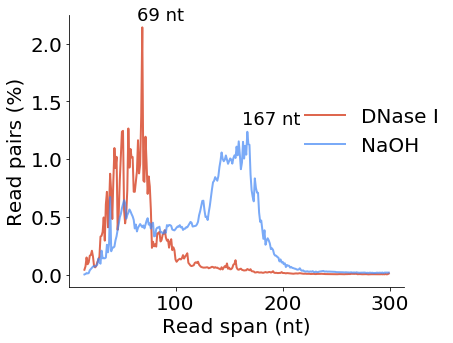

In [7]:
fig = plt.figure(figsize = (6,5))
ax_insert = fig.add_subplot(111)
idf = plot_insert(ax_insert, samples = ['DNase I',
                                       'NaOH'])#, 'Untreated', 'Unfragmented'])#,
                                     # "DNase I - 3'P" ])
sns.despine()
#ax_insert.set_ylim(0,2)
ax_insert.text(64, 2.2, '69 nt', fontsize=18)
#ax_insert.text(44, 1.6, '50 nt', fontsize=18)
ax_insert.text(162, 1.3, '167 nt', fontsize=18)
#ax_insert.text(129, 1.1, '130 nt', fontsize=18)

fig.savefig(figure_path + '/insert_plots_noExo.pdf', bbox_inches = 'tight')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:124: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  nthreads=int_use_threads)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


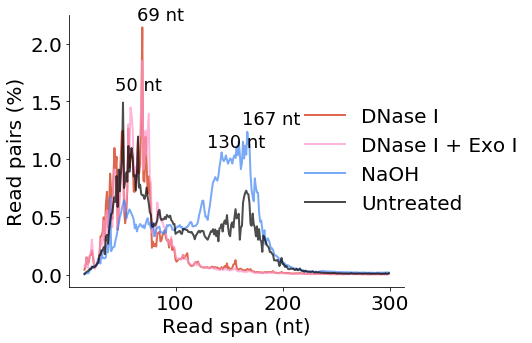

In [8]:
fig = plt.figure(figsize = (6,5))
ax_insert = fig.add_subplot(111)
idf = plot_insert(ax_insert, samples = ['DNase I', 'DNase I + Exo I',
                                       'NaOH', 'Untreated', 'Unfragmented'])#,
                                     # "DNase I - 3'P" ])
sns.despine()
#ax_insert.set_ylim(0,2)
ax_insert.text(64, 2.2, '69 nt', fontsize=18)
ax_insert.text(44, 1.6, '50 nt', fontsize=18)
ax_insert.text(162, 1.3, '167 nt', fontsize=18)
ax_insert.text(129, 1.1, '130 nt', fontsize=18)

fig.savefig(figure_path + '/insert_plots.pdf', bbox_inches = 'tight')

In [9]:
idf.groupby('label').apply(lambda d: d[d.size_fraction==d.size_fraction.max()])

,,label,isize,size_fraction
label,,,,
DNase I,4036,DNase I,69,2.140200
DNase I + Exo I,909,DNase I + Exo I,69,1.850043
NaOH,152,NaOH,167,1.236227
Untreated,4303,Untreated,51,1.489092


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:124: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  nthreads=int_use_threads)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels
/stor/home/cdw2854/cfNA/plots/count_plot.py:32: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pd.read_table(metric, skiprows=6, nrows=1)\
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:124: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  nthreads=int_use_threads)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = ind

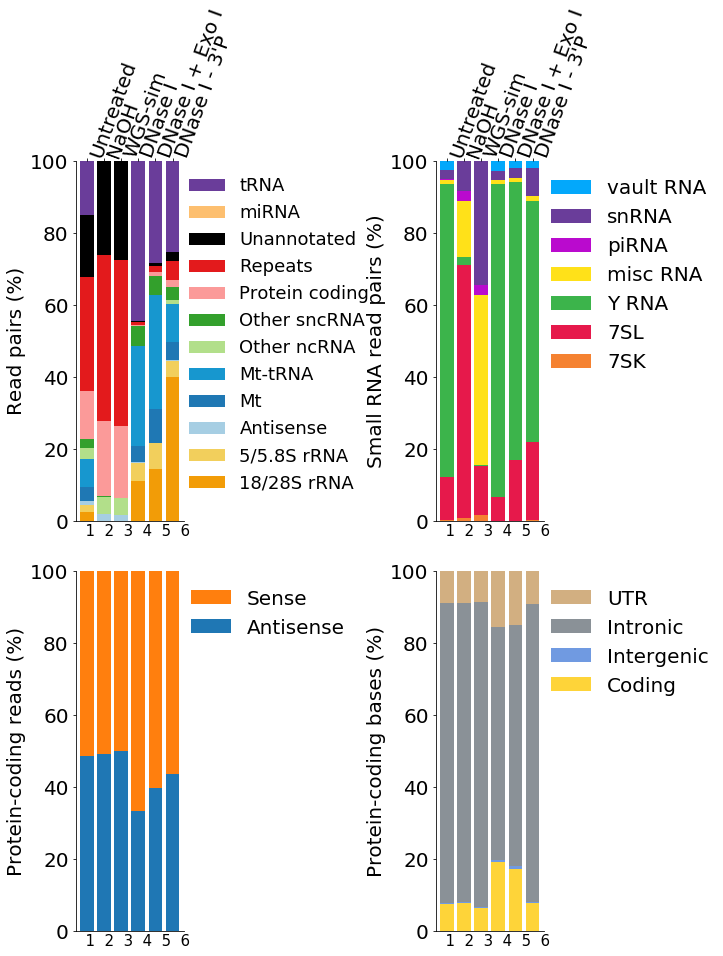

In [10]:
#fig = plt.figure(figsize = (10,8))
#ax_frag_dist = fig.add_axes([0,0,0.15,0.5])
#ax_frag_dist_feature_only = fig.add_axes([0.5,0,0.15,0.5])
#ax_strand = fig.add_axes([1,0,0.15,0.5])
#ax_coding = fig.add_axes([1.4,0,0.15,0.5])

fig = plt.figure(figsize = (10,10))
ax_frag_dist = fig.add_axes([0,0.52,0.15,0.5])
#ax_frag_dist_feature_only = fig.add_axes([0.5,0.52,0.15,0.5])
ax_small_RNA = fig.add_axes([0.5, 0.52, 0.15,0.5])
ax_strand = fig.add_axes([0,-0.05,0.15,0.5])
ax_coding = fig.add_axes([0.5, -0.05, 0.15, 0.5])


cdf = plot_count(ax_frag_dist, feature_only=False)
#cdf = plot_count(ax_frag_dist_feature_only, feature_only=True)
plot_strand(ax_strand)
plot_coding_bases(ax_coding)
plot_small_count_bar(ax_small_RNA)
ax_small_RNA.set_ylim(0,100)
ax_strand.xaxis.set_visible(False)
ax_coding.xaxis.set_visible(False)
ax_coding.set_ylim(0,100)
ax_strand.set_ylim(0,100)
ax_frag_dist.xaxis.tick_top()
#ax_frag_dist_feature_only.xaxis.tick_top()
ax_small_RNA.xaxis.tick_top()
fig.text(0,0.5,'  1  2  3  4  5  6', fontsize=15)
fig.text(0.5,0.5,'  1  2  3  4  5  6', fontsize=15)
fig.text(0, -0.07,'  1  2  3  4  5  6', fontsize=15)
fig.text(0.5, -0.07,'  1  2  3  4  5  6', fontsize=15)


#fig.tight_layout()
fig.savefig(figure_path + '/fragment_plots.pdf', bbox_inches = 'tight')

In [11]:
cdf

grouped_type,18/28S rRNA,5/5.8S rRNA,Antisense,Mt,Mt-tRNA,Other ncRNA,Other sncRNA,Protein coding,Repeats,Unannotated,miRNA,tRNA
treatment,,,,,,,,,,,,
DNase I,11.016633,5.219746,0.019639,4.622965,27.727097,0.105085,5.372594,0.461961,0.827948,0.201596,0.003042,44.421694
DNase I + Exo I,14.561520,7.156052,0.053047,9.294362,31.576787,0.164833,5.180355,1.161740,1.715133,0.689249,0.006318,28.440604
DNase I - 3'P,39.868102,4.657684,0.156484,4.903998,10.729331,1.089110,3.576100,2.071158,5.269577,2.269655,0.011845,25.396955
Fragmented,54.608525,2.851614,0.349003,8.928917,4.063244,1.197155,2.708681,4.529629,10.322406,5.226789,0.029637,5.184400
High salt (450mM),5.743792,2.212972,0.024915,19.979306,62.881969,0.160616,1.817984,0.455486,0.872419,0.413808,0.001752,5.434979
NaOH,0.107788,0.012248,1.720195,0.065456,0.049330,4.743235,0.129668,20.907699,46.102549,26.075078,0.062978,0.023776
Poly(A)-selected,2.634301,0.057940,2.403360,24.265031,0.702644,9.268910,1.712173,44.719941,8.704078,5.233085,0.179385,0.119153
Untreated,2.444537,1.982804,1.119537,3.810679,7.962004,3.044438,2.280723,13.352507,31.833530,17.253279,0.043508,14.872454
WGS-sim,0.001565,0.000620,1.684674,0.002924,0.000931,4.576801,0.048286,20.031861,46.026360,27.604646,0.021051,0.000282


In [13]:
small_df = pd.read_feather(work_path + '/cfNA/tgirt_map/Counts/all_counts/all_counts.feather') \
        .query("dedup == 'dedup'")\
        .assign(grouped_type = lambda d: d.gene_type.map(change_gene_type)) \
        .assign(grouped_type = lambda d: list(map(recat_rRNA, d.gene_name, d.grouped_type)))\
        .assign(grouped_type = lambda d: np.where(d.gene_name.str.contains('^MT-'),'Mt', d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.gene_name.str.contains('^MT-T'),'Mt-tRNA', d.grouped_type))\
        .groupby(['gene_type','grouped_type','samplename'], as_index=False)\
        .agg({'read_count':'sum'})
small_df.head()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:124: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  nthreads=int_use_threads)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,gene_type,grouped_type,samplename,read_count
0,18S_rRNA,18/28S rRNA,MPCEV_R1_001,85106
1,18S_rRNA,18/28S rRNA,MPCEVb_R1_001,30366
2,18S_rRNA,18/28S rRNA,MPF10_R1_001,12961
3,18S_rRNA,18/28S rRNA,MPF10b_R1_001,94124
4,18S_rRNA,18/28S rRNA,MPF4_R1_001,13172


In [14]:
detail = True
gt = 'grouped_type' if not detail else 'gene_type'
grouped_fraction = small_df\
    .assign(prep = lambda d: d.samplename.map(label_sample))\
    .assign(frag_frac = lambda d: d.groupby(['samplename'])\
                .read_count\
                .transform(lambda x: 100*x/x.sum())) \
    .groupby(['prep','gene_type'], as_index=False)\
    .agg({'frag_frac':['min','max']})
grouped_fraction.head()
grouped_fraction \
    .pipe(lambda d: d[d.prep=="DNase I"])

prep                           gene_type  frag_frac           
                                                        min        max
88   DNase I                            18S_rRNA   1.435117   5.061093
89   DNase I                            28S_rRNA   2.978549  12.984232
90   DNase I            3prime_overlapping_ncRNA   0.000023   0.000325
91   DNase I                           5.8S_rRNA   1.161817   4.876949
92   DNase I                             5S_rRNA   1.054033   2.724666
93   DNase I                                 7SK   0.000493   0.010021
94   DNase I                                 7SL   0.124963   0.482827
95   DNase I                           IG_C_gene   0.000087   0.000341
96   DNase I                     IG_C_pseudogene   0.000035   0.000059
97   DNase I                           IG_D_gene   0.000058   0.000058
98   DNase I                           IG_J_gene   0.000027   0.000069
99   DNase I                           IG_V_gene   0.000035   0.000266
100  DNase I                     IG_V_pseudogene   0.000035   0.000104
101  DNase I                             Mt_rRNA   3.133297   8.594389
102  DNase I                             Mt_tRNA  18.940514  49.515998
103  DNase I                         No features   0.143580   0.655632
104  DNase I                             Repeats   0.000207   1.734474
105  DNase I                                 TEC   0.000311   0.001377
106  DNase I                           TR_C_gene   0.000020   0.000080
107  DNase I                           TR_J_gene   0.000017   0.000089
108  DNase I                           TR_V_gene   0.000017   0.000153
109  DNase I                     TR_V_pseudogene   0.000024   0.000024
110  DNase I                               Y-RNA   2.722014   4.643872
111  DNase I                           antisense   0.016829   0.057061
112  DNase I       bidirectional_promoter_lncRNA   0.000114   0.000849
113  DNase I                             lincRNA   0.036474   0.109326
114  DNase I                        macro_lncRNA   0.000027   0.000038
115  DNase I                               miRNA   0.002959   0.016962
116  DNase I                            misc_RNA   0.009982   0.120362
117  DNase I                               piRNA   0.000682   0.001358
118  DNase I              polymorphic_pseudogene   0.000069   0.000412
119  DNase I                processed_pseudogene   0.014907   0.045732
120  DNase I                processed_transcript   0.005771   0.012326
121  DNase I                      protein_coding   0.000017   1.245068
122  DNase I                          pseudogene   0.000536   0.001767
123  DNase I                                rRNA   0.000023   0.000023
124  DNase I                      sense_intronic   0.000484   0.002135
125  DNase I                   sense_overlapping   0.000551   0.002318
126  DNase I                               snRNA   0.041740   0.147335
127  DNase I                              snoRNA   0.004370   0.019282
128  DNase I                                tRNA   0.001820  56.692426
129  DNase I    transcribed_processed_pseudogene   0.001209   0.007491
130  DNase I      transcribed_unitary_pseudogene   0.000380   0.002020
131  DNase I  transcribed_unprocessed_pseudogene   0.003283   0.009824
132  DNase I     translated_processed_pseudogene   0.000024   0.000086
133  DNase I                  unitary_pseudogene   0.000017   0.000407
134  DNase I              unprocessed_pseudogene   0.003804   0.007549
135  DNase I                            vaultRNA   0.068123   0.164400

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:124: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  nthreads=int_use_threads)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Written /stor/work/Lambowitz/yaojun/Work/cfNA/tgirt_map/figure/smallRNA_pie.pdf


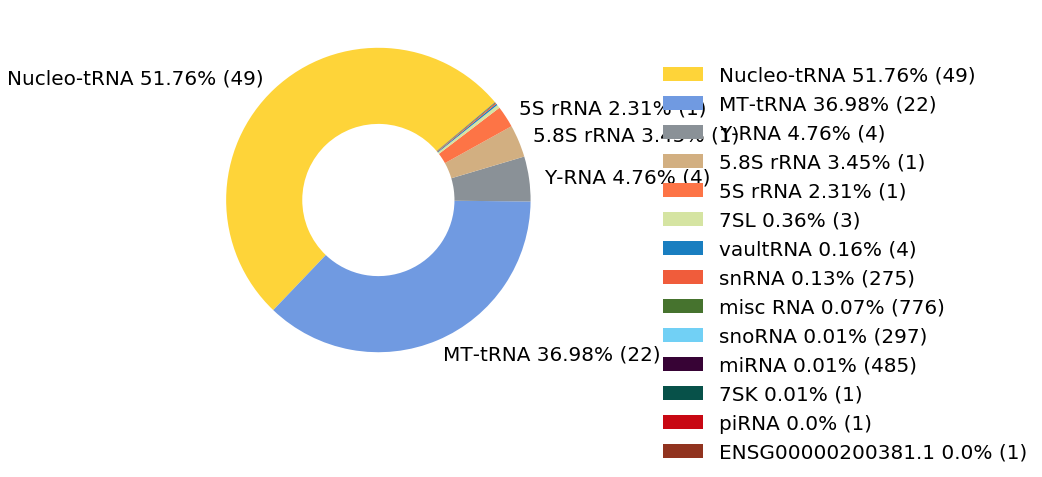

In [15]:
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
plot_small_count_pie(ax)
figurename = figure_path + '/smallRNA_pie.pdf'
fig.savefig(figurename, bbox_inches='tight')
print('Written %s' %figurename)

# plot EV#

In [16]:
countplot_df = read_count(feature_only=True, dedup='dedup', rna_group_type = 'grouped_type',
                          col_regex='type|Q[cC][fF]1[123]|PP|MP')
countplot_df.head()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:124: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  nthreads=int_use_threads)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


grouped_type,18/28S rRNA,5/5.8S rRNA,Antisense,Mt,Mt-tRNA,Other ncRNA,Other sncRNA,Protein coding,Repeats,miRNA,tRNA
treatment,,,,,,,,,,,
Crude,2.008941,2.191535,0.013075,0.017555,0.263942,0.042090,1.985945,0.206060,1.043367,0.119094,92.108395
Crude (MNase),1.985068,2.304151,0.014096,0.012256,0.204694,0.049114,1.982209,0.210366,0.457305,0.154624,92.626115
DNase I,13.714879,5.854409,0.015654,3.665313,20.285575,0.113985,4.817833,0.255336,0.870241,0.003362,50.403412
EV,1.223178,1.143666,0.036790,0.002613,0.047100,0.094741,1.283717,0.560182,0.864528,0.256235,94.487251
EV (MNase),1.694377,1.448455,0.015819,0.004429,0.073556,0.043251,1.633411,0.232206,0.582522,0.183978,94.087997


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:124: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  nthreads=int_use_threads)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


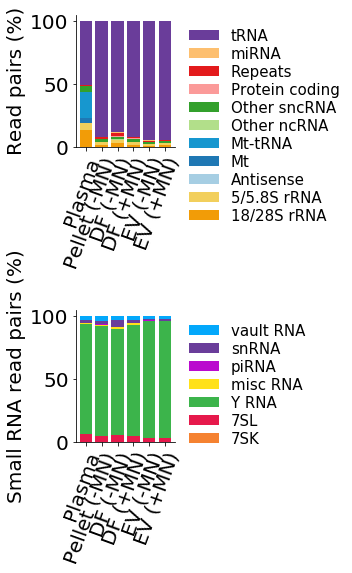

In [17]:
fig = plt.figure(figsize=(5,8))
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
ax = fig.add_subplot(211)
colors = rna_type_ce.transform(countplot_df.columns).tolist()
sample_rename = {'DNase I':'Plasma',
                'RNP (MNase)':'DF (+MN)',
                 'RNP':'DF (-MN)',
                'EV (MNase)':'EV (+MN)',
                 'EV':'EV (-MN)',
                 'Crude (MNase)':'Pellet (+MN)',
                'Crude': 'Pellet (-MN)'}
countplot_df = countplot_df.rename(sample_rename).rename(lambda x: x.replace('RNP','DF'))

plot_order = ['Plasma','Pellet (-MN)', 
                  'DF (-MN)','DF (+MN)',
                  'EV (-MN)','EV (+MN)',]
countplot_df.loc[plot_order,:]\
    .plot.bar(stacked=True, color = colors, ax = ax, width=0.8)
ax.legend()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title = '', 
          fontsize=15, frameon=False, bbox_to_anchor=(1,1),
          labelspacing=.2)
xts = []
for xt in ax.get_xticklabels():
    t = xt.get_text()
    t = t.replace('Crude','Pellet')
    t = t.replace('DNase I','Plasma')
    xts.append(t)
xt = ax.set_xticklabels(xts, 
                       rotation = 70, 
                       ha = 'right', 
                       rotation_mode="anchor")

ax.set_ylabel('Read pairs (%)')
ax.set_xlabel('')
sns.despine()



ax = fig.add_subplot(212)
small_RNA_ce = plot_small_count_bar(ax, prep_regex = 'DNase I$|Crude|EV|RNP',
                    label_order = ['DNase I','Crude', 'RNP','RNP (MNase)','EV','EV (MNase)'])
ax.legend()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title = '', 
          fontsize=15, frameon=False, bbox_to_anchor=(1,1),
          labelspacing=.2)
xts = []
for xt in ax.get_xticklabels():
    t = xt.get_text()
    t = sample_rename[t]
    xts.append(t)
xt = ax.set_xticklabels(xts, 
                       rotation = 70, 
                       ha = 'right', 
                       rotation_mode="anchor")
fig.tight_layout()
fig.savefig(figure_path + '/EV_count.pdf', bbox_inches='tight')

In [18]:
countplot_df

grouped_type,18/28S rRNA,5/5.8S rRNA,Antisense,Mt,Mt-tRNA,Other ncRNA,Other sncRNA,Protein coding,Repeats,miRNA,tRNA
treatment,,,,,,,,,,,
Pellet (-MN),2.008941,2.191535,0.013075,0.017555,0.263942,0.042090,1.985945,0.206060,1.043367,0.119094,92.108395
Pellet (+MN),1.985068,2.304151,0.014096,0.012256,0.204694,0.049114,1.982209,0.210366,0.457305,0.154624,92.626115
Plasma,13.714879,5.854409,0.015654,3.665313,20.285575,0.113985,4.817833,0.255336,0.870241,0.003362,50.403412
EV (-MN),1.223178,1.143666,0.036790,0.002613,0.047100,0.094741,1.283717,0.560182,0.864528,0.256235,94.487251
EV (+MN),1.694377,1.448455,0.015819,0.004429,0.073556,0.043251,1.633411,0.232206,0.582522,0.183978,94.087997
DF (-MN),3.688486,1.871191,0.062057,0.028182,0.415933,0.169803,1.617327,0.832921,2.962926,0.173599,88.177574
DF (+MN),1.838572,2.293740,0.024453,0.017285,0.282091,0.076368,2.132843,0.372855,0.875783,0.109578,91.976432


In [19]:
from collections import defaultdict
dedup_df = pd.read_feather(work_path + '/cfNA/tgirt_map/Counts/all_counts/all_counts.feather', nthreads=24) \
    .query('dedup == "dedup"')\
    .pipe(lambda d: d[d.samplename.str.contains('Qcf|EV|PF')]) \
    .assign(grouped_type = lambda d: d.gene_type.map(change_gene_type)) \
    .assign(prep = lambda d: d.samplename.map(label_sample)) 
dedup_df.head()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: the 'nthreads' keyword is deprecated, use 'use_threads' instead
  
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:124: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  nthreads=int_use_threads)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,samplename,strand,gene_type,gene_name,gene_id,dedup,read_count,grouped_type,prep
1,MPCEV_R1_001,antisense,18S_rRNA,18S_rRNA,18S_rRNA,dedup,478,rRNA,Crude
3,MPCEV_R1_001,antisense,28S_rRNA,28S_rRNA,28S_rRNA,dedup,898,rRNA,Crude
5,MPCEV_R1_001,antisense,5.8S_rRNA,5.8S_rRNA,5.8S_rRNA,dedup,224,rRNA,Crude
7,MPCEV_R1_001,antisense,5S_rRNA,5S_rRNA,5S_rRNA,dedup,126,rRNA,Crude
9,MPCEV_R1_001,antisense,7SK,RN7SK,RN7SK,dedup,6,Other sncRNA,Crude


In [20]:
from sequencing_tools.stats_tools import normalize_count

comp_df = dedup_df\
    .pipe(lambda d: d[~pd.isnull(d.prep)])\
    .pipe(lambda d: d[d.prep.str.contains('DNase I$|RNP|EV|Crude')]) \
    .pipe(lambda d: d[d.grouped_type != "rRNA"])\
    .query('gene_type != "No features"')\
    .assign(grouped_type = lambda d: np.where((d.gene_name.str.contains('MT')) & (d.grouped_type=="tRNA"),
                    'Mt-tRNA',d.grouped_type))\
    .assign(gene_name = lambda d: np.where(d.grouped_type == "tRNA", 
                                           d.gene_name.str.extract('^(TR[A-Z]+-[ACTGN]{3})-',expand=False), 
                                           d.gene_name))\
    .assign(gene_id = lambda d: np.where(d.grouped_type == "tRNA", d.gene_name, d.gene_id))\
    .groupby(['gene_name','gene_id','grouped_type','gene_type','prep'], as_index=False)\
    .agg({'read_count':'sum'})\
    .pipe(pd.pivot_table, index=['gene_name','gene_id', 'gene_type','grouped_type'],
         values = 'read_count', columns = 'prep', fill_value=0)\
    .pipe(normalize_count)\
    .reset_index()\
    .pipe(pd.melt,id_vars = ['DNase I','gene_name','gene_id','gene_type','grouped_type'], 
          var_name = 'prep', value_name = 'norm_count')  \
    .assign(prep = lambda d: d.prep.str.replace('EV\+RNP|RNP\+EV','Crude')) \
    .sort_values('prep') 
comp_df.head()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/numpy/lib/shape_base.py:357: RuntimeWarning: divide by zero encountered in log
  res = asanyarray(func1d(inarr_view[ind0], *args, **kwargs))
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/numpy/lib/shape_base.py:380: RuntimeWarning: divide by zero encountered in log
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


,DNase I,gene_name,gene_id,gene_type,grouped_type,prep,norm_count
0,1.134916,A1BG,ENSG00000121410.11_3,protein_coding,Protein coding,Crude,0.000000
25504,0.378305,RP11-405F3.5,ENSG00000261633.1_4,antisense,Antisense,Crude,2.919235
25505,0.000000,RP11-405M12.3,ENSG00000278607.1_4,lincRNA,Other ncRNA,Crude,0.000000
25506,0.000000,RP11-405O10.2,ENSG00000225092.2_5,sense_intronic,Other ncRNA,Crude,0.000000
25507,0.378305,RP11-406A20.1,ENSG00000237626.1_4,lincRNA,Other ncRNA,Crude,0.000000


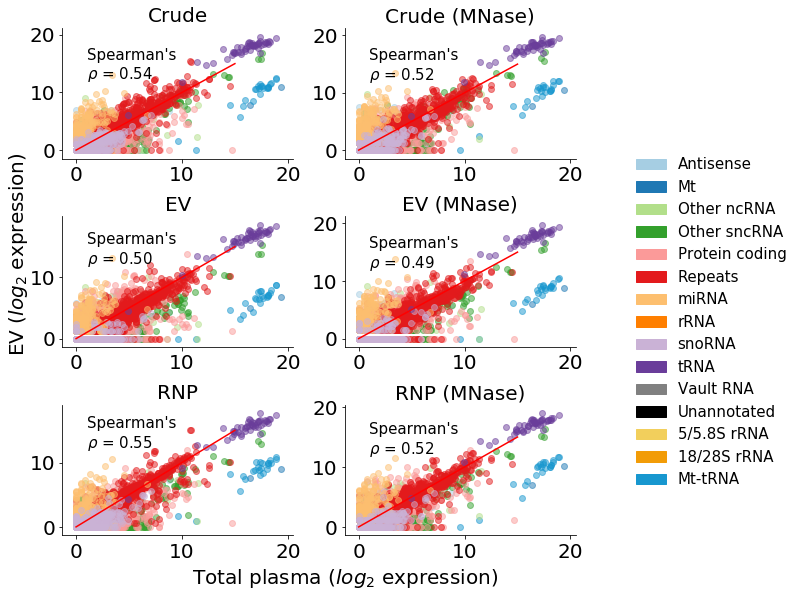

In [21]:
fig = plt.figure(figsize=(8,8))
rna_type_ce
for i, (prep, prep_df) in enumerate(comp_df.groupby('prep')):
    ax = fig.add_subplot(3,2,i+1)
    
    for gt, gtdf in prep_df.groupby('grouped_type'):
        color = rna_type_ce.encoder[gt]
        xs = np.log2(gtdf['DNase I']+1)
        ys = np.log2(gtdf['norm_count']+1)
        ax.scatter(xs, ys, color = color, alpha=0.5)
    r, p = spearmanr(np.log(prep_df['DNase I']+1),
             np.log(prep_df['norm_count']+1))
    ax.plot([0,15],[0,15], color = 'red')
    ax.set_title(prep, size=20)
    ax.text(1,12, "Spearman's\n" r'$\rho$ = %.2f' %r, fontsize=15)
fig.tight_layout()
sns.despine()
rna_type_ce.show_legend(ax = ax, bbox_to_anchor = (1.2,3), frameon=False,
                       fontsize=15)
fig.text(-0.02,0.7, 'EV ($log{_2}$ expression)', fontsize=20, rotation=90)
fig.text(0.3, -0.02, 'Total plasma ($log_2$ expression)', fontsize=20)
fig.savefig(figure_path + '/EV_scatter_gene.png', bbox_inches='tight')

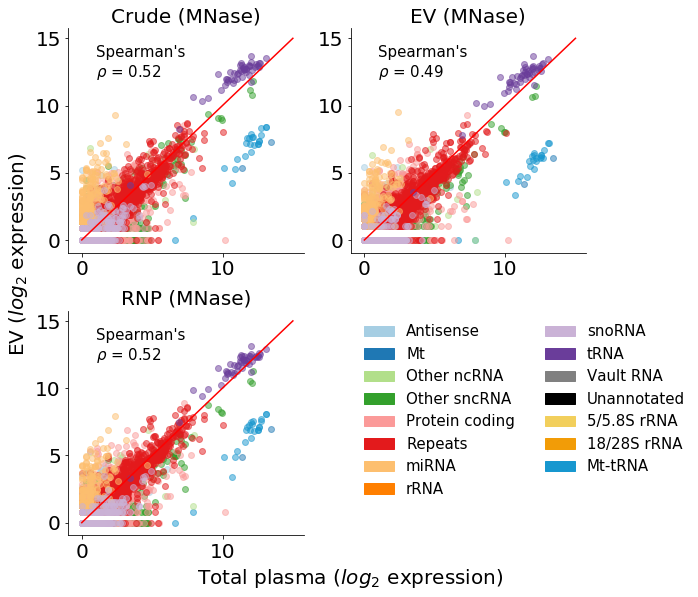

In [22]:
fig = plt.figure(figsize=(8,8))
for i, (prep, prep_df) in enumerate(comp_df\
                            .pipe(lambda d: d[d.prep.str.contains('MNase')])\
                            .groupby('prep')):
    ax = fig.add_subplot(2,2,i+1)
    
    for gt, gtdf in prep_df.groupby('grouped_type'):
        color = rna_type_ce.encoder[gt]
        xs = np.log(gtdf['DNase I']+1)
        ys = np.log(gtdf['norm_count']+1)
        ax.scatter(xs, ys, color = color, alpha=0.5)

    ax.plot([0,15],[0,15], color = 'red')
    ax.set_title(prep, size=20)
    r, p = spearmanr(np.log(prep_df['DNase I']+1),
             np.log(prep_df['norm_count']+1))
    ax.text(1,12, "Spearman's\n" r'$\rho$ = %.2f' %r, fontsize=15)
fig.tight_layout()
sns.despine()
ax = fig.add_subplot(2,2,4)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)
rna_type_ce.show_legend(ax = ax, frameon=False,
                       fontsize=15, ncol=2,
                       loc='upper left')
fig.text(-0.03,0.7, 'EV ($log{_2}$ expression)', fontsize=20, rotation=90)
fig.text(0.3, -0.02, 'Total plasma ($log{_2}$ expression)', fontsize=20)
fig.savefig(figure_path + '/EV_mnase_scatter_gene.png', bbox_inches='tight')

In [62]:
comp_df.prep.unique()

array(['Crude', 'Crude (MNase)', 'EV', 'EV (MNase)', 'RNP', 'RNP (MNase)'],
      dtype=object)

In [58]:
def plot_comparison(fig, y_sample = 'EV (MNase)', x_sample = 'DNase I', annotation=True):
    EV_df = comp_df \
        .query('prep== "%s" | prep == "%s"' %(y_sample, x_sample)) 
    RNAtypes = ['Total', 'Protein coding', 'sncRNA', 'miRNA']
    for i, RNAtype in enumerate(RNAtypes):
        if RNAtype == 'Total':
            plot_df = EV_df
            color_type = 'grouped_type'
            encoder = rna_type_ce
    
        elif RNAtype == "Protein coding":
            plot_df = EV_df.query('grouped_type=="Protein coding"')
            color_type = 'grouped_type'
            encoder = rna_type_ce

    
        elif RNAtype == 'sncRNA':
            plot_df = EV_df\
                .pipe(lambda d: d[d.grouped_type.str.contains('tRNA|snoRNA|Vault|sncRNA')])\
                .query('gene_type!="Mt_tRNA"')\
                .assign(gene_type = lambda d: d.gene_type.str.replace('_',' ')) \
                .assign(gene_type = lambda d: d.gene_type.str.replace('Y\-','Y ')) \
                .assign(gene_type = lambda d: d.gene_type.str.replace('vault','vault ')) 
            color_type = 'gene_type'
            encoder = small_RNA_ce 
    
        elif RNAtype == "miRNA":
            plot_df = EV_df.query('grouped_type == "miRNA"')
            color_type = 'gene_type'
            encoder = rna_type_ce 
    
        plot_df.reset_index(inplace=True, drop=True)
        ax = fig.add_subplot(2,2,i+1)
    
        if RNAtype == "Protein coding":
            k_df = make_gene_df(get_tpm_df())
            plot_scatter_kallisto(k_df, x_sample, y_sample, ax, cor_value=annotation)
            if annotation:
                kallisto_encoder.show_legend(ax = ax, fontsize=12, frameon=False,
                                            loc = 'upper left')
        
        else:
            if x_sample != 'DNase I':
                col_names = plot_df.columns.tolist()
                col_names.remove('prep')
                col_names.remove('norm_count')
                plot_df = plot_df\
                    .pipe(pd.pivot_table, index=col_names, 
                          columns = 'prep', values='norm_count')\
                    .reset_index()
                x = np.log(plot_df[x_sample] + 1)
                y = np.log(plot_df[y_sample] + 1)
            else:
                x = np.log(plot_df[x_sample]+1)
                y = np.log(plot_df['norm_count']+1)
            colors = np.array(plot_df[color_type].map(encoder.encoder))
            for i, (color, ct) in enumerate(zip(colors, plot_df[color_type])):
                if pd.isnull(color):
                    colors[i] = rna_type_ce.encoder[ct]
            plot_df.loc[:, 'colors'] = colors
            _ce = color_encoder()
            _ce.encoder = {row[color_type]:row['colors'] for i, row in plot_df.filter(['colors',color_type]).drop_duplicates().iterrows()}
            if 'snRNA' in _ce.encoder.keys():
                _ce.encoder['snRNA'] = '#000000'
            ax.scatter(x,y, color = colors)
            ax.legend().set_visible(False)
            if RNAtype != "miRNA" and annotation:
                _ce.show_legend(ax=ax, frameon=False, fontsize=12, loc = 'upper left')
            ax.plot([0,max(y.max(), x.max())+5],[0,max(x.max(), y.max())+5], color = 'red')
            r, p = spearmanr(x,y)
            if annotation:
                ax.text(x.max()+2,1, "Spearman's\n" r'$\rho$ = %.2f' %r, fontsize=20)
    
    
        ## annotations ##
        if annotation:
            ax.set_title(RNAtype, size=25)
        
        else:
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
    
    sns.despine()
    fig.tight_layout()
    if x_sample == 'DNase I':
        x = 'Total plasma'
        y = y_sample.replace('Crude','Pellet').replace(' (MNase)','')
    else:
        x = x_sample.replace('Crude','Pellet').replace('RNP','DF').replace(' (MNase)','')
        if x_sample.endswith('(MNase)'):
            x += ' +MN'
        else:
            x += ' -MN'
        
        y = y_sample.replace('Crude','Pellet').replace('RNP','DF').replace(' (MNase)','')
        if y_sample.endswith('(MNase)'):
            y += ' +MN'
        else:
            y += ' -MN'        
            
    if annotation:
        fig.text(0.4, -0.01, '%s ($log{_2}$ expression)' %x, fontsize=25)
        fig.text(-0.01,0.6, '%s ($log{_2}$ expression)' %y, 
                 rotation = 90, fontsize=25)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/stor/home/cdw2854/cfNA/plots/kallisto_plots.py:98: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pd.read_table(tpm_table) \
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/stor/work/Lambowitz/cd

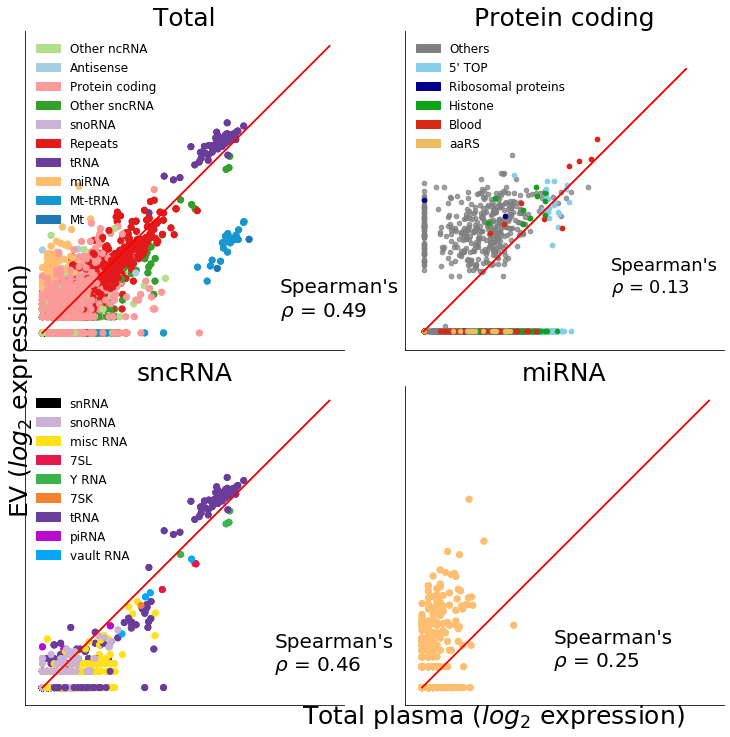

In [67]:
fig = plt.figure(figsize=(10,10))
for _format in ['png', 'eps']:
    plot_comparison(fig, annotation = _format != 'png')
    figurename = figure_path + '/EV_scatter_plots/EV_plasma_scatter.%s' %(_format)
    fig.savefig(figurename, bbox_inches='tight')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/stor/home/cdw2854/cfNA/plots/kallisto_plots.py:98: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pd.read_table(tpm_table) \
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/stor/work/Lambowitz/cd

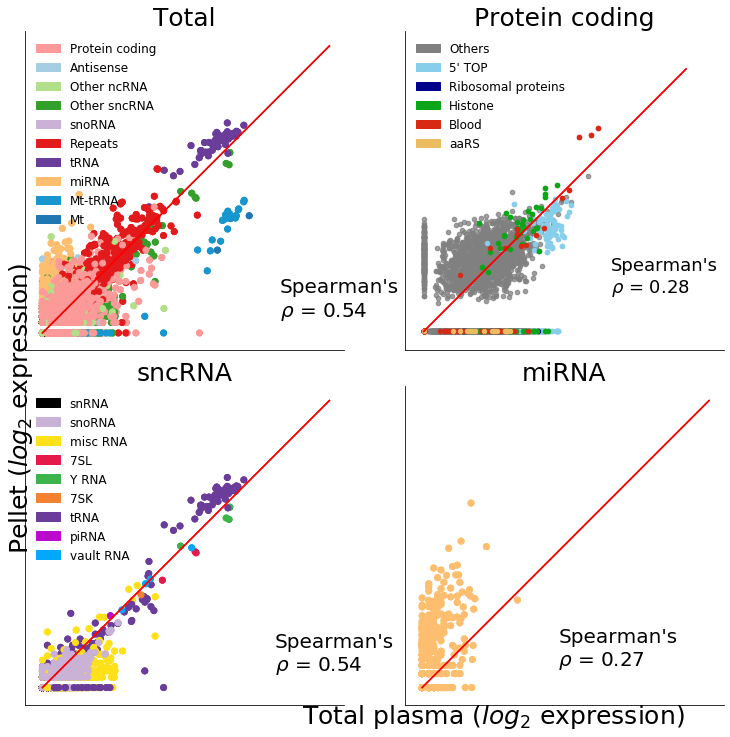

In [69]:
fig = plt.figure(figsize=(10,10))
for _format in ['png', 'eps']:
    plot_comparison(fig, y_sample = 'Crude', annotation = _format != 'png')
    figurename = figure_path + '/EV_scatter_plots/pellet_noMNase_plasma_scatter.%s' %_format
    fig.savefig(figurename, bbox_inches='tight')

/stor/home/cdw2854/cfNA/plots/kallisto_plots.py:98: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pd.read_table(tpm_table) \
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppresse

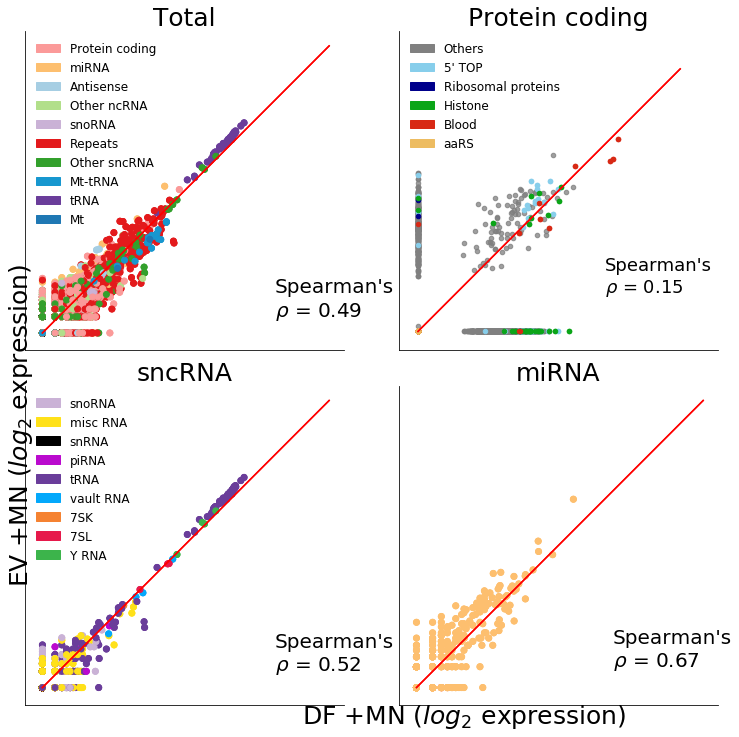

In [74]:
fig = plt.figure(figsize=(10,10))
for _format in ['png', 'eps']:
    plot_comparison(fig, y_sample = 'EV (MNase)', x_sample = 'RNP (MNase)', annotation = _format != 'png')
    figurename = figure_path + '/EV_scatter_plots/EV_vs_DF_pellet_scatter.%s' %_format
    fig.savefig(figurename, bbox_inches='tight')

/stor/home/cdw2854/cfNA/plots/kallisto_plots.py:98: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pd.read_table(tpm_table) \
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppresse

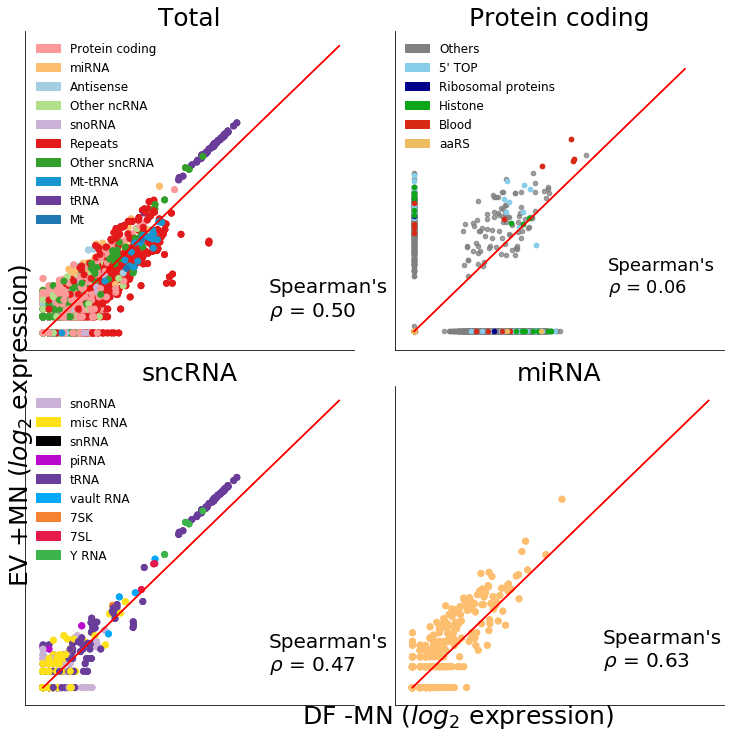

In [75]:
fig = plt.figure(figsize=(10,10))
for _format in ['png', 'eps']:
    plot_comparison(fig, y_sample = 'EV (MNase)', x_sample = 'RNP', annotation = _format != 'png')
    figurename = figure_path + '/EV_scatter_plots/EV_vs_DF_noMNase_pellet_scatter.%s' %_format
    fig.savefig(figurename, bbox_inches='tight')

/stor/home/cdw2854/cfNA/plots/kallisto_plots.py:98: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pd.read_table(tpm_table) \
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppresse

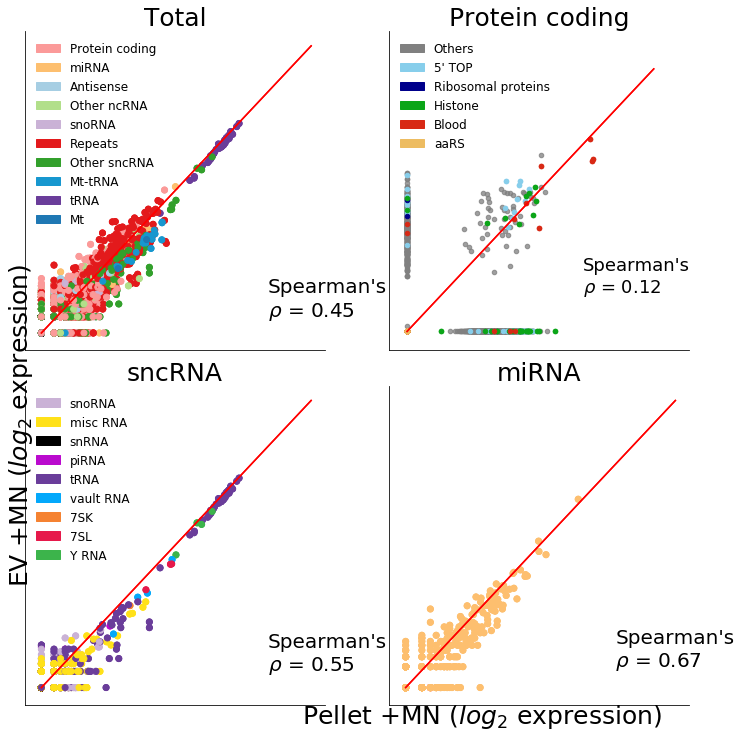

In [76]:
fig = plt.figure(figsize=(10,10))
for _format in ['png', 'eps']:
    plot_comparison(fig, y_sample = 'EV (MNase)', x_sample = 'Crude (MNase)', annotation = _format != 'png')
    figurename = figure_path + '/EV_scatter_plots/EV_vs_pellet_scatter.%s' %_format
    fig.savefig(figurename, bbox_inches='tight')

/stor/home/cdw2854/cfNA/plots/kallisto_plots.py:98: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pd.read_table(tpm_table) \
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppresse

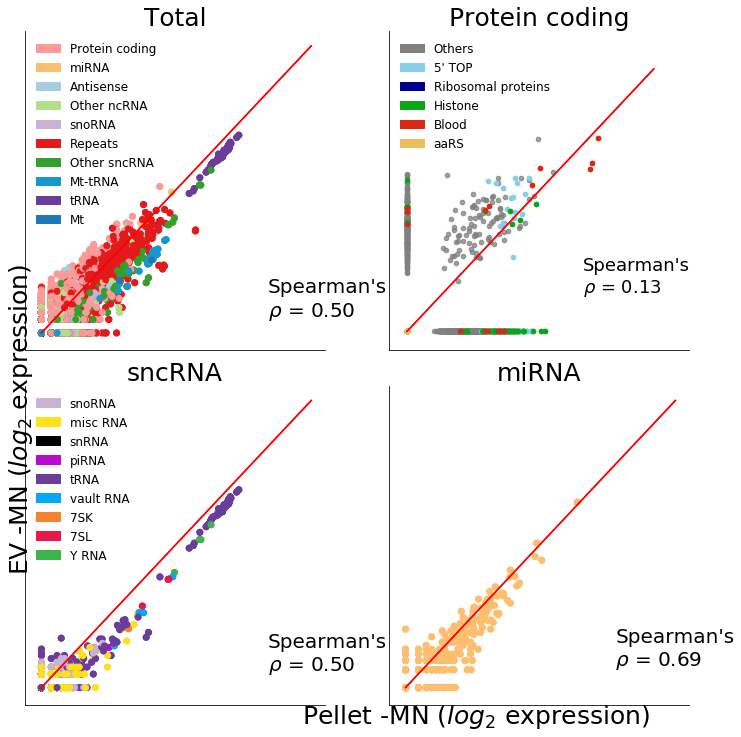

In [77]:
fig = plt.figure(figsize=(10,10))
for _format in ['png', 'eps']:
    plot_comparison(fig, y_sample = 'EV', x_sample = 'Crude', annotation = _format != 'png')
    figurename = figure_path + '/EV_scatter_plots/EV_noMNase_vs_pellet_noMNase_scatter.%s' %_format
    fig.savefig(figurename, bbox_inches='tight')

/stor/home/cdw2854/cfNA/plots/kallisto_plots.py:98: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pd.read_table(tpm_table) \
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppresse

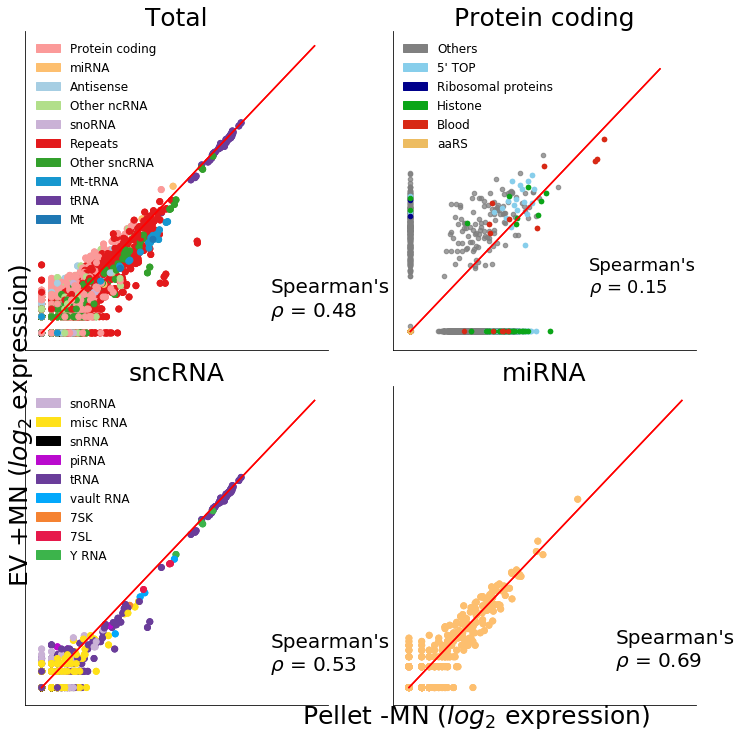

In [78]:
fig = plt.figure(figsize=(10,10))
for _format in ['png', 'eps']:
    plot_comparison(fig, y_sample = 'EV (MNase)', x_sample = 'Crude', annotation = _format != 'png')
    figurename = figure_path + '/EV_scatter_plots/EV_vs_pellet_noMNase_scatter.%s' %_format
    fig.savefig(figurename, bbox_inches='tight')

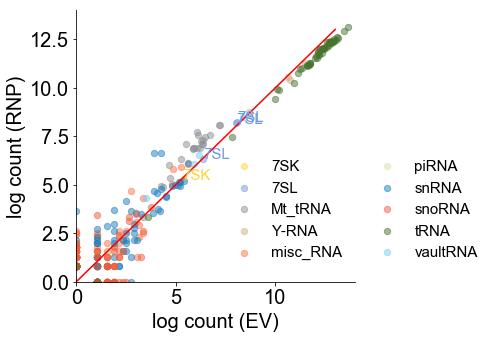

In [17]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
EV_df = comp_df\
    .pipe(lambda d: d[d.prep.str.contains('MNase')])\
    .pipe(lambda d: d[d.prep.str.contains('EV|RNP')]) \
    .query('norm_count > 0')\
    .assign(log_count = lambda d: np.log(d.norm_count+1))\
    .pipe(pd.pivot_table, columns = 'prep', 
          values = 'log_count', fill_value=0, 
          index=['gene_id','gene_type','grouped_type'])\
    .reset_index()\
    .pipe(lambda d: d[d.grouped_type.str.contains('tRNA|^Y|sn|7S')])
    
for i, (gt, gt_df) in enumerate(EV_df.sort_values('gene_type').groupby('gene_type')):
    gt_df.plot.scatter('EV (MNase)', 'RNP (MNase)', 
                       alpha=0.5, s=40,
                       label = gt,
                       color = simpsons_palette()[i],
                      ax = ax)
    for j, row in gt_df.iterrows():
        if row['gene_type'] in ['7SK','7SL']:
            ax.text(row['EV (MNase)'], 
                    row['RNP (MNase)'],
                   row['gene_type'], 
                    color = simpsons_palette()[i],
                    fontsize=15)
ax.set_ylabel('log count (RNP)')
ax.set_xlabel('log count (EV)')
ax.plot([0,13], [0,13], color='red')
ax.legend(bbox_to_anchor=(0.5,0.5), 
        frameon=False, fontsize=15,
        ncol=2)
sns.despine()
ax.set_xlim(0,14)
ax.set_ylim(0,14)
figurename = figure_path + '/EV-RNP_scatter.png'
fig.savefig(figurename, bbox_inches='tight')

In [18]:
comp_df\
    .pipe(lambda d: d[d.prep.str.contains('MNase')])\
    .groupby(['grouped_type','prep'], as_index=False)\
    .agg({'norm_count':'sum'})\
    .assign(frac = lambda d: d.groupby('prep').norm_count.transform(lambda x: 100*x/x.sum())) \
    .groupby(['grouped_type'], as_index=False)\
    .agg({'frac':['min','max']})

grouped_type       frac           
                         min        max
0       Antisense   0.030740   0.051820
1              Mt   0.004099   0.015098
2         Mt-tRNA   0.081603   0.335421
3     Other ncRNA   0.082044   0.144136
4    Other sncRNA   1.676094   2.199295
5  Protein coding   0.427954   0.808592
6         Repeats   0.844536   1.545014
7           miRNA   0.125688   0.199158
8          snoRNA   0.002611   0.004797
9            tRNA  94.770139  96.520041

In [19]:
dedup_df \
    .pipe(lambda d: d[~d.samplename.str.contains('[qQ][cC][fF][0-9]_')]) \
    .pipe(lambda d: d[d.samplename.str.contains('[qQ][cC][fF][0-9]+_')])\
    .samplename.unique()

array(['Qcf10_R1_001', 'Qcf11_R1_001', 'Qcf12_R1_001', 'Qcf13_R1_001'],
      dtype=object)

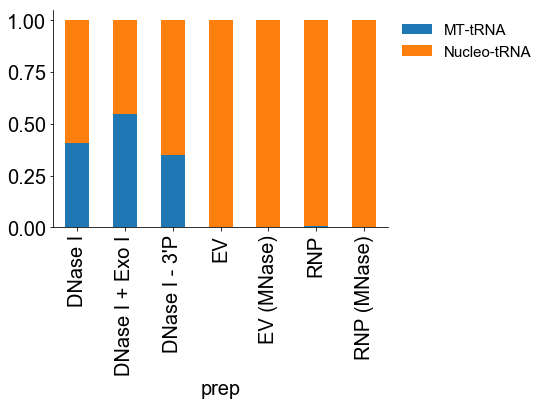

In [20]:
ax = plt.subplot()
dedup_df \
    .pipe(lambda d: d[~pd.isnull(d.prep)])\
    .pipe(lambda d: d[~d.samplename.str.contains('[qQ][cC][fF][0-9]_')])\
    .pipe(lambda d: d[d.prep.str.contains('DNase|EV|RNP')]) \
    .query('grouped_type == "tRNA"')\
    .assign(is_mt = lambda d: np.where(d.gene_name.str.contains('MT'), 'MT-tRNA','Nucleo-tRNA')) \
    .groupby(['prep','is_mt'], as_index=False)\
    .agg({'read_count':'sum'}) \
    .assign(read_fraction = lambda d: d.groupby('prep').read_count.transform(lambda x: x/x.sum()))\
    .pipe(pd.pivot_table, columns = 'is_mt', index='prep', values='read_fraction')\
    .plot.bar(stacked=True, ax=ax)
ax.legend(bbox_to_anchor = (1,1), frameon=False, fontsize=15, title='')
sns.despine()

In [21]:
dedup_df.filter(['prep','samplename']).drop_duplicates()

,prep,samplename
1,Crude,MPCEV_R1_001
15235,Crude,MPCEVb_R1_001
63441,RNP,MPF10_R1_001
119885,RNP,MPF10b_R1_001
159785,EV,MPF4_R1_001
189833,EV,MPF4b_R1_001
208011,Crude (MNase),PPCEV_R1_001
218929,Crude (MNase),PPCEVb_R1_001
263624,RNP (MNase),PPF10_R1_001
275880,RNP (MNase),PPF10b_R1_001


In [22]:
from sequencing_tools.viz_tools import cor_plot
from sequencing_tools.stats_tools import normalize_count

spreaded_df = dedup_df\
    .pipe(lambda d: d[~pd.isnull(d.prep)])\
    .pipe(lambda d: d[d.prep.str.contains('DNase|EV|RNP')]) \
    .assign(gene_name = lambda d: d.gene_name.str.replace('-[0-9]+',''))\
    .groupby(['prep','gene_name','grouped_type'], as_index=False)\
    .agg({'read_count':'sum'})\
    .pipe(pd.pivot_table, columns = 'prep', values = 'read_count',
         index=['gene_name','grouped_type'], fill_value = 0)  
spreaded_df.head()

,prep,DNase I,DNase I + Exo I,DNase I - 3'P,EV,EV (MNase),RNP,RNP (MNase)
gene_name,grouped_type,,,,,,,
.,No features,131396,164214,1675184,36788,23420,106432,35844
18S_rRNA,rRNA,1193612,557730,1416238,22184,46514,107085,46251
28S_rRNA,rRNA,2956366,1079925,4228398,33672,70368,155733,77237
5.8S_rRNA,rRNA,1160429,346574,500892,31028,65022,78175,97561
5S_rRNA,rRNA,720546,284186,227437,17621,32854,53093,52711


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


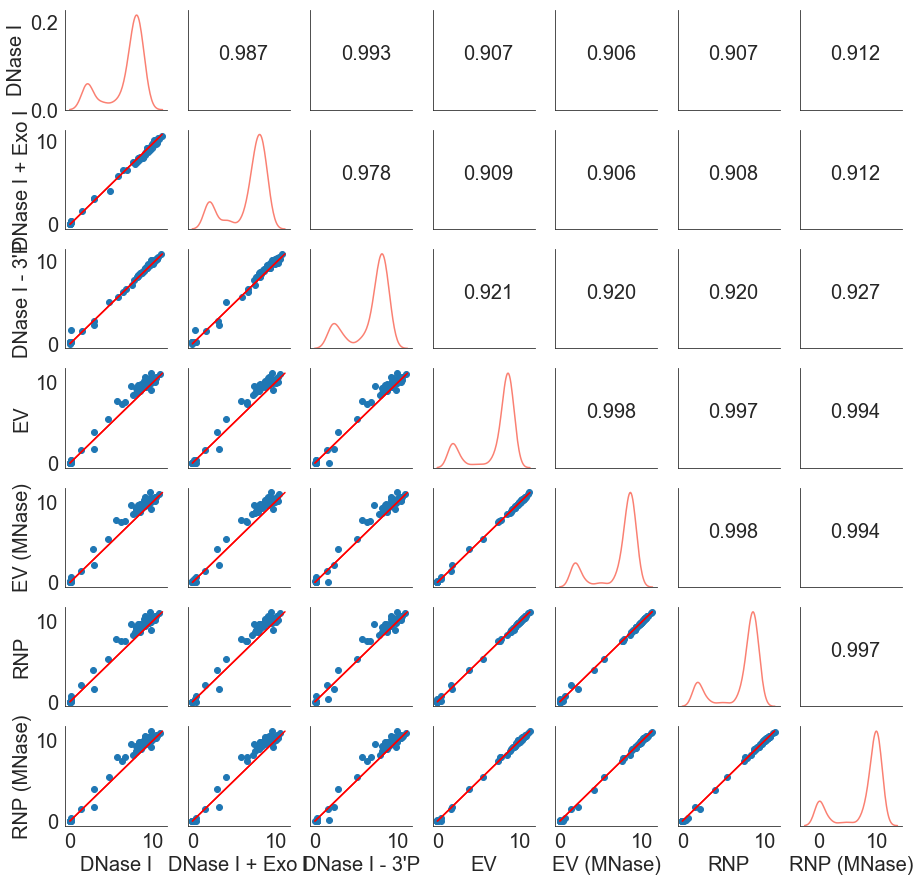

In [23]:
fig = plt.figure(figsize=(15,15))
spreaded_df\
    .reset_index()\
    .query('grouped_type == "tRNA"')\
    .drop('grouped_type', axis=1)\
    .set_index('gene_name')\
    .transform(lambda x: x/x.sum(axis=0)*1e6)\
    .transform(lambda x: np.log(x+1)) \
    .reset_index()\
    .pipe(lambda d: d[~d.gene_name.str.contains('^MT')])\
    .drop(['gene_name'], axis=1) \
    .pipe(cor_plot, fig, method = 'spearman')


In [24]:
from collections import defaultdict
    dedup_df = pd.read_feather('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/Counts/all_counts/spreaded_all_counts.feather')
cor_df = np.log(dedup_df\
                .filter(regex = 'Qcf|QCF|PP|MP')\
                .filter(regex="dedup:sense") \
                .pipe(lambda d: d[d.columns[~d.columns.str.contains('LE[0-9]+')]])\
                .pipe(lambda d: d+1))
cor_df.columns = rename_sample(cor_df.columns)
cor_df = cor_df.corr(method='pearson')
p = sns.clustermap(cor_df, cmap = 'viridis')
ax = p.ax_heatmap
xt = ax.set_xticks(range(cor_df.shape[0]))
yt = ax.set_yticks(range(cor_df.shape[1]))
xt = ax.set_xticklabels(cor_df.columns[p.dendrogram_col.reordered_ind])
yt = ax.set_yticklabels(cor_df.index[p.dendrogram_row.reordered_ind])

yt = ax.set_yticks(np.arange(cor_df.shape[1])+0.5)
xt = ax.set_xticks(np.arange(cor_df.shape[0])+0.5)

ce = color_encoder()
ce.fit(cor_df.columns.str.replace(' [0-9]+$',''), 
                 simpsons_palette())
for xt in ax.get_xmajorticklabels():
    color = ce.encoder[re.sub(' [0-9]+$','', xt.get_text())]
    xt.set_color(color)
    
for yt in ax.get_ymajorticklabels():
    color = ce.encoder[re.sub(' [0-9]+$','', yt.get_text())]
    yt.set_color(color)

pat = [mpatches.Patch(color=col, label=lab) for lab, col in ce.encoder.items()]
ax.legend(handles=pat, bbox_to_anchor = (1.6,0.), fontsize=15)
p.fig.text(0.1, 0.86, r"Pearson's $\rho$", rotation = 90, fontsize=15)

IndentationError: unexpected indent (<ipython-input-24-6c8e4de0df30>, line 2)

In [ ]:
dedup_df = pd.read_feather('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/Counts/all_counts/spreaded_all_counts.feather')


filter_feature = 'No features' 
dedup_regex = ':dedup:' 
norm_df = dedup_df \
        .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.grouped_type.str.contains('Y-RNA'), 'Other sncRNA', d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.grouped_type.str.contains("vaultRNA|VT|vt"),'Vault RNA', d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.gene_name.str.contains('^MT-'),'Mt',d.grouped_type))\
        .pipe(lambda d: d[d.columns[~d.columns.str.contains('anti')]])\
        .pipe(lambda d: d[d.grouped_type.isin(['rRNA','tRNA','snoRNA','snRNA','Other sncRNA','MT'])])\
        .groupby(['gene_id','gene_name','gene_type','grouped_type'])\
        .sum()\
        .pipe(lambda d: d[d.columns[d.columns.str.contains(dedup_regex)]]) \
        .filter(regex='[Qq][cC][fF][0-9]+|[Pp]hos')\
        .pipe(normalize_count)\
        .reset_index()\
        .pipe(pd.melt, id_vars = ['gene_id','gene_name','gene_type','grouped_type'], 
              var_name = 'samplename', value_name = 'norm_count') 
norm_df.head()

In [ ]:
rRNA_df = norm_df.query('grouped_type =="rRNA"') \
    .assign(prep = lambda d: d.samplename.map(label_sample)) \
    .reset_index(drop=True) 
rRNA_df.head()

In [ ]:
ax = plt.subplot(111)
sns.swarmplot(data = rRNA_df, 
              x = 'gene_name', 
              y = 'norm_count',
              dodge=True,
              hue='prep', ax =ax)
ax.set_yscale('log')
ax.set_ylabel('Normalized count')
ax.set_xlabel('rRNA')
sns.despine()

In [ ]:
norm_df = dedup_df \
        .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.grouped_type.str.contains('Y-RNA'), 'Other sncRNA', d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.grouped_type.str.contains("vaultRNA|VT|vt"),'Vault RNA', d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.gene_name.str.contains('^MT-'),'Mt',d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.gene_name.str.contains('^MT-T'),'Mt-tRNA',d.grouped_type))\
        .pipe(lambda d: d[d.columns[~d.columns.str.contains('anti')]])\
        .pipe(lambda d: d[d.grouped_type.isin(['rRNA','tRNA','snoRNA','snRNA','Other sncRNA','Mt','Mt-tRNA'])])\
        .groupby(['gene_name','gene_type','grouped_type'])\
        .sum()\
        .pipe(lambda d: d[d.columns[d.columns.str.contains(dedup_regex)]]) \
        .filter(regex='[Qq][cC][fF][0-9]+|[Pp]hos|^[MP]P')\
        .reset_index()\
        .pipe(pd.melt, id_vars = ['gene_name','gene_type','grouped_type'], 
              var_name = 'samplename', value_name = 'norm_count') \
        .assign(prep = lambda d: d.samplename.map(label_sample)) 
norm_df.head()

In [ ]:
norm_plot_df = norm_df \
    .groupby(['grouped_type','samplename'], as_index=False)\
    .agg({'norm_count':'sum'}) \
    .assign(prep = lambda d: d.samplename.map(label_sample))\
    .assign(cpm = lambda d: d.groupby('samplename').norm_count.transform(lambda x: 1e6*x/x.sum()))
norm_plot_df.head()

In [ ]:
ax = plt.subplot(111)
sns.swarmplot(data=norm_plot_df, hue ='prep', 
              x = 'grouped_type', y ='cpm',
             dodge=True)
ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1,1), frameon=False)
sns.despine()
xts = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [ ]:
pi_df = norm_df\
    .groupby(['gene_type','prep','samplename'], as_index=False)\
    .agg({'norm_count':'sum'})\
    .pipe(lambda d: d[d.samplename.str.contains('^[Qq][cC][fF][0-9]+')])\
    .assign(norm_fraction = lambda d: d.groupby(['prep','samplename']).norm_count.transform(lambda x: 100*x/x.sum())) \
    .pipe(lambda d: d[d.gene_type.str.contains('rRNA')])\
    .pipe(lambda d: d[~d.gene_type.str.contains('Mt')])\
    .groupby(['gene_type'], as_index=False)\
    .agg({'norm_count':'sum'})\
    .assign(fraction = lambda d: d.norm_count.transform(lambda x: 100*x/x.sum()))
pi_df.head()

In [ ]:
68+25

In [ ]:
norm_df

In [ ]:
x = pi_df.query('prep=="DNase I"').norm_fraction.tolist()
y = pi_df.query('prep=="DNase I - 3\'P"').norm_fraction.tolist()
from scipy.stats import ranksums

ranksums(x,y)

In [33]:
len(dedup_df.query('prep=="DNase I"').query('read_count > 0').gene_id.unique())

28916